<a href="https://colab.research.google.com/github/DavideRutigliano/ANNDL/blob/master/Challenge2%5BU_Net_DenseNet201_BCE_Jaccard_68.9%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU

We found colab assigning randomly a GPU among Tesla K80, P4 and P100. The following code only runs on K80 and P100 (the one given also by kaggle for kaggle kernels), because P4 does not have enough memory. We also found K80 to be slower than P100 as expected. Our advice if running the notebook on colab is to reset the runtime until the following cell outpus a P100 GPU.

In [0]:
!nvidia-smi

## Install Useful Packages

In [0]:
%%capture

!pip install tensorflow-gpu==1.14.0
#!pip install efficientnet

## Import Libraries

In [0]:
%%capture

import os
import multiprocessing as mp
import gc

from functools import partial

import numpy as np
np.random.seed(1234)

import pandas as pd

import cv2

import imgaug as ia
ia.seed(1234)
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.model_selection import train_test_split

from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

#try:
#    %tensorflow_version 2.x
#except:
#    pass

#%tensorflow_version 1.x

import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_first')

#from efficientnet.tfkeras import EfficientNetB0

### Set tensorflow workspace

In [0]:
print("Tensorflow version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    gpu = gpus[0]
    print("Using GPU(s):", gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    #if tf.__version__ == '2.0.0':
    #    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
    # NOTE: needs for input_shape to have channels_first to be effective
    #    tf.keras.backend.set_image_data_format('channels_first')
else:
    print("Not using GPU")

Tensorflow version: 1.14.0
Using GPU(s): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [0]:
%%capture

!pip uninstall -y kaggle && pip install kaggle

In [0]:
os.environ["KAGGLE_USERNAME"] = "lazcoder"
os.environ["KAGGLE_KEY"] = "f8513d63f03470f5f848e303e747159c"

raw_data_dir = "input/raw"
!rm -r {raw_data_dir}
!kaggle datasets download -d lazcoder/anndl-segmentation-jpeg -p {raw_data_dir}

In [0]:
%%capture

!apt-get install fuse-zip

In [0]:
#%%capture

input_dir = "../input/ann-and-dl-image-segmentation/"

!rm -r ../input/ann-and-dl-image-segmentation/
!mkdir ../input/
!mkdir ../input/ann-and-dl-image-segmentation/

!fuse-zip {raw_data_dir}/anndl-segmentation-jpeg.zip {input_dir}

In [0]:
!ls {input_dir}

#/Segmentation_Dataset

## Data Preparation

As the dataset size is quite big (and it fits almost all the RAM of kaggle kernels) we decided to use filenames instead of image (and masks) numpy arrays in order to be memory efficient (obviously, with a time/memory trade-off).

Thus, we read images for training/validation one batch at once with the data generator.

We did not used any particular preprocessing, we only convert images from 'bgr' (default cv2) to 'rgb' and masks to 'grayscale' (one channel images).

In [0]:
input_dir = "../input/anndl-segmentation-jpeg/" #Segmentation_Dataset/"
train_dir = input_dir + "training"

In [0]:
classes = [
    'background',
    'building'
]

n_classes = len(classes)

In [0]:
filenames = os.listdir(train_dir + "/images/img")

print("Training data:", len(filenames))

Training data: 7647


### Train/Validation split

We decided to use a validation split size of $20\%$ as it results in enough data to get almost accurate validation score.

In [0]:
filenames_train, filenames_val = train_test_split(filenames,
                                                  test_size=.2,
                                                  shuffle=True,
                                                  random_state=1234)

print("Training data (after split):", len(filenames_train))
print("Validation data:", len(filenames_val))

Training data (after split): 6117
Validation data: 1530


In [0]:
dataset_split = {
    "training" : filenames_train,
    "validation" : filenames_val
}

import json

filename = 'dataset_split.json'

with open(filename, 'w') as fp:
    json.dump(dataset_split, fp)

#with open(filename) as infile:
#    data = json.load(infile)

#pd.DataFrame(dataset_split)

In [0]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, 256, 256)
else:
    input_shape = (256, 256, 3)

def preprocess(img, image_size, mask): 
    img = cv2.resize(img, image_size)
        
    if mask == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img
    
def preprocess_input(images, input_shape, mask=False):
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = (input_shape[1], input_shape[2])
    else:    
        image_size = (input_shape[0], input_shape[1])

    func_preprocess = partial(preprocess,
                              image_size=image_size,
                              mask=mask)
    
    map_iterator = map(func_preprocess, images)
    resized = list(map_iterator)

    return resized

def display(display_list, title=['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()

### Pixel-wise class weights (TL;DR)

As in the U-Net paper, we calculate a weight map for each training sample in order to force the network to learn the borders. The weight map is essentially an image (of the same shape of the mask given in input) in which each pixel is the weight of the corresponding pixel in the original mask. The weights are calculated as follows:

Denote as $y$ the ground truth (i.e. the mask to be predicted), given an initial weight $w_0$ and a standard deviation $\sigma$ and a weight for each class $w_c(y) = (w_{c_0}(y), ..., w_{c_n}(y)), n \in N_{classes}$ where $y$ is the original mask, the weight map is:

$w(y) = w_c(y) + w_0 \cdot e^{-\frac{1}{2}\cdot\left(\frac{d1 + d2}{\sigma}\right)^2}$

$w_c$ is the weight for balancing classes (in our case 2 weights one for background and one for building, applied to each pixel of the mask), $d1$ and $d2$ are the distances to the border of respectively the nearest and the second nearest cells. The distances are calculated through a morphological operation. We use default values (the same used in the paper) for $w_0 = 10$ and $\sigma = 5$.

Finally, the weighted loss is calculated as pixel-wise binary cross entropy $\left(BCE\right)$ times the weight map.
$L(y, \hat{y}) = \sum{}{w(y) \cdot BCE(y, \hat{y})}$, where the sum is over all the pixel in the mask and $\hat{y}$ is the predicted mask.

#### Note

This function as it is is quite slow even after some attempts of python code optimization. We compute the weight map each time we calculate the loss and this results in slowing down training time. A solution colud be (as they also do in the paper) pre-compute class weights, but this leads to other problems such as doing augmentation, shuffling and all operations done for training images also on class weights; thus, we decided to use this function as it is and calculate the weigths each time the loss is calculated.

In [0]:
def calculate_weights(elem, y, class_weights):
    k = elem[0]
    v = elem[1]
    class_weights[y == k] = v
    return class_weights

def calculate_distances(idx, labels, label_ids):
    label_id = label_ids[idx]
    distance = distance_transform_edt(labels != label_id)
    return distance

def unet_weight_map(y,
                    wc=None,
                    w0=10,
                    sigma=5):

    labels = label(y)
    no_labels = labels == 0
    unique = np.unique(labels)
    label_ids = sorted(unique)[1:]

    if len(label_ids) > 1:
        
        if tf.keras.backend.image_data_format() == 'channels_first':
            shape = (len(label_ids), y.shape[1], y.shape[2])

        else:
            shape = (len(label_ids), y.shape[0], y.shape[1])
        
        distances = np.zeros(shape, dtype=np.float32)

        func_distances = partial(calculate_distances,
                                 labels=labels,
                                 label_ids=label_ids)
        
        indexes = range(len(label_ids))

        map_iterator = map(func_distances, indexes)
        
        distances = np.array(list(map_iterator), dtype=np.float32) #the real bottleneck
        distances.sort(axis=0, kind='stable') #stable uses timsort (slightly faster)

        d1 = distances[0,:,:]
        d2 = distances[1,:,:]
                
        w = w0 * np.exp(-1/2 * ((d1 + d2) / sigma)**2) * no_labels

    else:
        w = np.zeros_like(y, dtype=np.float32)
        
    if wc is not None:

        class_weights = np.zeros_like(y, dtype=np.float32)

        if isinstance(wc, dict):
            wc = wc.values()
        
        func_weights = partial(calculate_weights,
                               y=y,
                               class_weights=class_weights)
        
        
        map_iterator = map(func_weights, enumerate(wc))
        class_weights = list(map_iterator)
        class_weights = np.mean(class_weights, axis=0)
        
        w = w + class_weights

    return w

### Plot images and masks

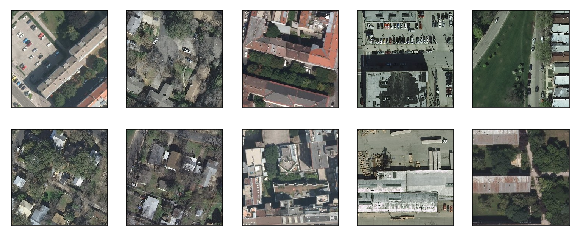

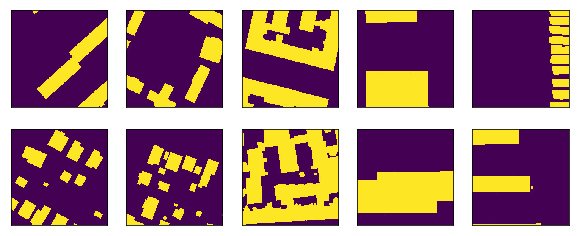

In [0]:
indexes = np.random.RandomState(1234).choice(range(0, len(filenames)), 10)

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = indexes[i]
    img = cv2.imread(train_dir + "/images/img/" + filenames[idx])
    img = preprocess_input([img], input_shape)
    img = np.array(img)[0]
    plt.imshow(img)

plt.show()

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = indexes[i]
    img = cv2.imread(train_dir + "/masks/img/" + filenames[idx])
    img = preprocess_input([img], input_shape, mask=True)
    img = np.array(img)[0]
    plt.imshow(img)

plt.show()

#fig = plt.figure(figsize=(10,4))

#for i in range(10):
#    plt.subplot(2,5,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    idx = indexes[i]
#    img = cv2.imread(train_dir + "/masks/img/" + filenames[idx])
#    img = preprocess_input([img], input_shape, mask=True)
#    img = unet_weight_map(np.array(img), wc=[1,1])
#    img = np.array(img)[0]
#    plt.imshow(img)

#plt.show()

## Data Generator

As for classification, we defined a custom data generator extending ```tensorflow.keras.Sequence``` class.

In this case we define a generator that takes in input a directory and a list of filenames and reads batch-wise images. The rationale behind this choice is to avoid RAM expolosion that will instead happen if using all the images (and subsequentially also masks) as numpy arrays.

We do not apply any particular preprocessing function, we only normalize images to have zero mean and unitary standard deviation. For masks instead, we rescale pixel values between $[0,1]$.

Finally, we apply the following data augmentations in random order:
* flips (both vertical $30\%$ and horizontal $40\%$)
* crops of $\left(-15, -5\right)\%$ of the original size (sort of zoom)
* random affine transformations: 
  * translations of $\left(-20, +20\right)\%$ on both axis
  * rescaling between $\left(80, 120\right)\%$ of the original size 
  * shearing between $\left(-8,+8\right)$ degrees
  * rotations of $\left(-25,+25\right)$ degrees

Note: for affine transformations we use padding mode "reflect" as pointed out in some discussion on kaggle and gives better results.

In [0]:
def normalize_input(img):
    
    img = img.astype('float32')
    
    #Normalize by mean and std deviation

    img = (img - img.mean()) / (img.std())
    
    #Normalize as for ImageNet
    
    #mean = [103.939, 116.779, 123.68]
    #img[..., 0] -= mean[0]
    #img[..., 1] -= mean[1]
    #img[..., 2] -= mean[2]

    #Normalize by scaling values in [-1,+1]
    
    #img /= 255.
    
    #img /= 127.5
    #img -= 1.
        
    return img

def read_image_mask(fname,
                    img_dir,
                    msk_dir,
                    read_image):
  
    img_path = img_dir + fname
    mask_path = msk_dir + fname
    curr_img = read_image(img_path)
    curr_mask = read_image(mask_path)

    return curr_img, curr_mask

def prepare_batch(idx, images, masks):
    
    img = images[idx]
    
    img = normalize_input(img)
    if tf.keras.backend.image_data_format() == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    
    msk = masks[idx]

    msk = msk[..., np.newaxis]
    msk /= 255.
    msk = np.round(msk).astype('float32')
    if tf.keras.backend.image_data_format() == 'channels_first':
        msk = np.rollaxis(msk, 2, 0)

    return img, msk

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 directory,
                 filenames,
                 batch_size,
                 input_shape,
                 shuffle=False,
                 augment=[],
                 n_augmentations=2):
        
        self.input_shape = input_shape
            
        self.original_filenames = filenames
        self.directory = directory
        
        self.img_dir = self.directory + "/images/img/"
        self.msk_dir = self.directory + "/masks/img/"
        
        self.func_read = partial(read_image_mask,
                                 img_dir=self.img_dir,
                                 msk_dir=self.msk_dir,
                                 read_image=cv2.imread)
        
        if tf.keras.backend.image_data_format() == 'channels_first':
            self.mask_shape = (1, self.input_shape[1], self.input_shape[2])
        else:
            self.mask_shape = (self.input_shape[0], self.input_shape[1], 1)
            
        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.augment = augment
        
        self.epoch = 0
        
        self.filenames = np.array(self.original_filenames)
        
        augmenters = []
        
        if 'flip' in self.augment:
            augmenters.append(iaa.Fliplr(.4))
            augmenters.append(iaa.Flipud(.3))
            
        if 'crop' in self.augment:
            augmenters.append(iaa.Sometimes(0.4,
                                  iaa.CropAndPad(percent=(-0.15, -0.05),
                                                 pad_mode=ia.ALL,
                                                 pad_cval=(0, 255))))
        
        if 'transform' in self.augment:
            transform = iaa.OneOf([
                iaa.Sometimes(.2, iaa.ElasticTransformation(alpha=(0.5, 3.5),
                                                            sigma=0.25)),
                iaa.Sometimes(.1, iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                iaa.Sometimes(.3, iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ])
            augmenters.append(transform)

        if 'edges' in self.augment:
            edges = iaa.OneOf([
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.05, .5)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
                                                   direction=(0.0, 1.0)),
                        ])),
            ])
            augmenters.append(edges)
            
        if 'emboss' in self.augment:
            emboss = iaa.Sometimes(0.3,
                                   iaa.Emboss(alpha=1, strength=1.5))
            augmenters.append(emboss)

        if 'blur' in self.augment:
            augmenters.append(iaa.GaussianBlur((0, 1.0)))
            
        if 'dropout' in self.augment:
            drop = iaa.Sometimes(0.3,
                                 iaa.CoarseDropout(p=.1,
                                                   size_percent=(.02, .08)))
            augmenters.append(drop)
            
        if 'superpixels' in self.augment:
            s_pix = iaa.Sometimes(0.3,
                                  iaa.Superpixels(
                                    p_replace=(0, 1.0),
                                    n_segments=(20, 200)
                                    )
                                 )
            augmenters.append(s_pix)

        if 'rotate' in self.augment:
            augmenters.append(iaa.Affine(rotate=(-25, 25),
                                         shear=(-8, 8),
                                         translate_percent={"x": (-0.2, 0.2),
                                                            "y": (-0.2, 0.2)},
                                         scale={"x": (0.8, 1.2),
                                                "y": (0.8, 1.2)},
                                         mode='reflect'))
            
        self.seq = None
        self.n_augmentations = n_augmentations

        if len(augmenters) > 0 and self.n_augmentations > 0:
            self.seq = iaa.Sequential(augmenters, random_order=True)
            for _ in range(self.n_augmentations):
                self.filenames = np.append(self.filenames,
                                           self.original_filenames)
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        
        self.epoch += 1

        if self.shuffle == True:
            seed = self.batch_size * self.epoch
                        
            self.filenames = sklearn_shuffle(self.filenames,
                                             random_state=seed)
            
        self.n = self.__len__()
        gc.collect()

    def __len__(self):
        # using ceil allows to use the full dataset plus some samples to
        # fill the last batch in case the number of sample is not divisible
        # by the batch size; these images are all black images (zeros array)
        # and their labels is all-zero array too (that is correct).
        # Thus we decided to use ceil instead of floor as the newly added
        # samples in case the batch is not full can't harm the results.

        return int(np.ceil(self.filenames.shape[0] / self.batch_size))
        
    def __getitem__(self, step):
        current_filenames = self.filenames[step * self.batch_size : \
                                           (step + 1) * self.batch_size]

        images, masks = self.__generate_batch(current_filenames, step)

        return images, masks
    
    def __generate_batch(self, filenames, step):
        
        map_iterator = map(self.func_read, filenames)
        map_list = list(map_iterator)
        map_batch = map(list, zip(*map_list))
        batch = list(map_batch)

        images = np.array(batch[0], dtype=np.float32)
        masks = np.array(batch[1], dtype=np.float32)

        images = preprocess_input(images, input_shape)
        masks = preprocess_input(masks, input_shape, mask=True)
            
        if step >= self.n//(1 + self.n_augmentations):
            if self.seq is not None:
                seq_det = self.seq.to_deterministic()
                images = seq_det.augment_images(images=images)
                masks = seq_det.augment_images(images=masks)

        func_prepare = partial(prepare_batch,
                               images=images,
                               masks=masks)
        
        indexes = range(len(images))
        
        map_iterator = map(func_prepare, indexes)
        map_list = list(map_iterator)
        map_batch = map(list, zip(*map_list))
        batch = list(map_batch)

        images = np.array(batch[0], dtype=np.float32)
        masks = np.array(batch[1], dtype=np.float32)

        return images, masks

In [0]:
batch_size = 16
all_aug = ['crop',
           #'emboss',
           #'dropout',
           #'superpixels',
           #'blur',
           'rotate',
           'flip']

augment = all_aug
shuffle = True

train_generator = DataGenerator(train_dir,
                                filenames_train,
                                batch_size=batch_size,
                                input_shape=input_shape,
                                augment=augment,
                                shuffle=shuffle)

validation_generator = DataGenerator(train_dir,
                                     filenames_val,
                                     batch_size=batch_size,
                                     input_shape=input_shape)

print("(%dx) Augmented images from %d batches (%d images) to %d batches (%d images)" % \
      (train_generator.n_augmentations, \
       len(filenames_train)//train_generator.batch_size, len(filenames_train), \
       train_generator.n, train_generator.n * train_generator.batch_size))

(2x) Augmented images from 382 batches (6117 images) to 1147 batches (18352 images)


### Show augmented images and masks

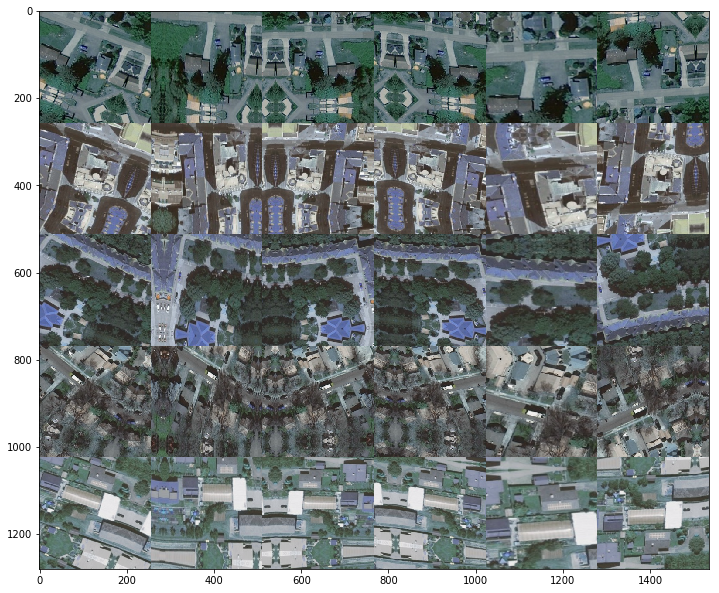

In [0]:
grid = train_generator.seq.to_deterministic()\
        .draw_grid([cv2.imread(train_dir + "/images/img/" + fname)\
                    for fname in filenames_train[:5]], 1, 6)

plt.figure(figsize=(12,12))
plt.imshow(np.uint8(grid))
plt.show()

In [0]:
%time item = train_generator.__getitem__(1016)

CPU times: user 164 ms, sys: 48 ms, total: 212 ms
Wall time: 311 ms


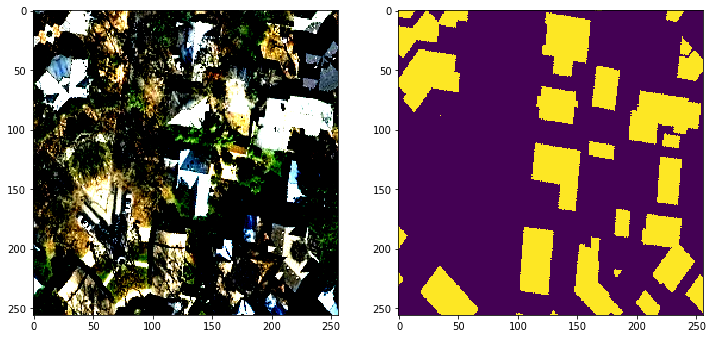

In [0]:
idx = np.random.randint(batch_size)

fig, ax = plt.subplots(1, 2, figsize=(12,12))

if tf.keras.backend.image_data_format() == 'channels_first':
    img = np.rollaxis(np.rollaxis(item[0][idx], 0, 2), 2, 1)
else:
    img = item[0][idx]

#weights = item[0][1][idx][0,:,:]
mask = item[1][idx][0,:,:]

ax[0].imshow(img)
ax[1].imshow(mask)
#ax[2].imshow(weights)
plt.show()

## Metrics and Losses

### Evaluation Metrics
The evaluation metrics we used are binary accuracy in order to have an idea of how well our model was performing to classify pixels (binary because in keras it rounds predictions) and the metric provided in the evaluation tab (i.e. intersection over union score).

<img src='https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png' width=30%/>

The IoU (Intersection over Union) is calculated accordingly to the following formula:

$IoU(A,B) = \frac{A \cap B}{A \cup B}$.

### Loss Functions

First, we used the standard binary classification loss, binary crossentropy (BCE):

$BCE(y,\hat{y}) = - \sum{y \cdot log(\hat{y}) + (1.0 - y) \cdot log(1.0 - \hat{y})}$.

Besides binary crossentropy, we tried several losses in order to get a better intersection over union score. The first we adopted was Jaccard loss and it directly optimizes the intersection over union score; indeed, the formula is simply:

$Jaccard(y,\hat{y}) = 1.0 - IoU(y,\hat{y})$.

We explored also other losses such as the focal loss, useful for unbalanced datasets, that needs a careful initialization of the network in order to not explode. The rationale of this loss function is that the loss for the minority class is higher than the loss for the majority class. The formula is:

$Focal(y,\hat{y}) = - \sum{y \cdot \alpha \cdot (1.0 - \hat{y})^{\gamma} \cdot log(\hat{y}) + (1.0 - y) \cdot (1.0 - \alpha) \cdot (\hat{y})^{\gamma} \cdot log(1.0 - \hat{y})}$

Where alpha is in the range $[0,1]$ and $\gamma \in [0, 5]$. Accordingly to the paper we used $\alpha=0.25$ and $\gamma=2.0$.

Finally, we used the same loss described in the U-Net paper (the same cited above for weight maps). This loss is essentially a binary crossentropy weighted per class and forced (by assigning higher weights) to learn the borders. The formula is the following:

$WBCE(y, \hat{y}) = - \sum{w(y) \cdot y \cdot log(\hat{y}) + (1.0 - y) \cdot log(1.0 - \hat{y})}$

### Combination of loss functions

Finally, we decided to use a linear combination of $BCE$ and $Jaccard$, accordingly to the following formula:

$L(y, \hat{y}) = \alpha \cdot BCE(y, \hat{y}) + (1.0 - \alpha) \cdot Jaccard(y, \hat{y})$

with $\alpha \in [0,1]$.

More precisely, we weight for $75\%$ the Jaccard loss and for $25\%$ the binary cross entropy, that is we choose $\alpha=0.25$.


In [0]:
def iou(y_true, y_pred):
    
    y_pred = tf.math.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + \
            tf.reduce_sum(y_pred) - intersection
        
    return intersection / union

def jaccard_loss(y_true, y_pred):
    
    # we do again the calculation of iou for the
    # calculation of the jaccard loss without rounding predictions
    # that is not permitted in loss functions as it is 
    # a non differentiable operation
    # it should give a more accurate jaccard score anyway
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + \
            tf.reduce_sum(y_pred) - intersection
    
    return 1. - intersection / union

def focal_loss(alpha=0.25, gamma=2.0):
    
    def loss(y_true, y_pred):
        
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)

        loss_1 = - y_true * (alpha * tf.math.pow((1 - y_pred), gamma) *\
                             tf.math.log(y_pred))

        loss_0 = - (1 - y_true) * ((1 - alpha) * tf.math.pow((y_pred), gamma) *\
                                   tf.math.log(1 - y_pred))

        focal_loss = tf.reduce_mean(loss_0 + loss_1)

        return focal_loss
    
    return loss

def tf_unet_weight_map(class_weights=None):

    @tf.function
    def func(tensor):

        if class_weights is not None:
            inp=[tensor, class_weights]
        else:
            inp=[tensor]
        
        weight_map = tf.numpy_function(unet_weight_map,
                                       inp,
                                       [tf.float32])
        
        return weight_map
        
    return func

def weighted_binary_crossentropy(class_weights=None):

    def loss(y_true, y_pred):

        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)

        loss_1 = - y_true * tf.math.log(y_pred)

        loss_0 = - (1 - y_true) * tf.math.log(1 - y_pred)
        
        bce = loss_0 + loss_1
        
        #bce = tf.keras.losses.BinaryCrossentropy()
        #bce = bce(y_true, y_pred)

        if class_weights is not None:
            weight_map = tf.map_fn(tf_unet_weight_map(
                                      class_weights=class_weights
                                   ),
                                   y_true,
                                   [tf.float32])

            wbce = tf.reduce_mean(weight_map * bce)

        else:

            wbce = tf.reduce_mean(bce)
        
        return wbce

    return loss

def combine_losses(l1, l2, alpha=None):

    def loss(y_true, y_pred):

        if alpha != None:
            return alpha * l1(y_true, y_pred) + (1. - alpha) * l2(y_true, y_pred)
        else:
            return l1(y_true, y_pred) + l2(y_true, y_pred)
    
    return loss

In [0]:
a = np.array([[[[1., 1., 1., 0., 1., 1.],
                [0., 0., 0., 0., 0., 0.],
                [1., 1., 1., 0., 0., 0.]]]])

b = np.array([[[[1., 1., 1., 0., 1., 1.],
                [0., 0., 0., 1., 1., 1.],
                [1., 1., 1., 0., 0., 0]]]])

c = np.array([[[[1., 1., 1., 0., 1., 1.],
                [0., 0., 0., 1., 1., 1.],
                [1., 1., 1., 0., 0., 0.]]]])

d = np.array([[[[1., 1., 1., 0., 1., 1.],
                [0., 0., 0., 0., 0., 0.,],
                [1., 1., 1., 0., 0., 0]]]])

print("IoU:", tf.keras.backend.eval(iou(a,b)))
print("=" * 30)
bce_fp = tf.keras.backend.eval(tf.keras.losses.BinaryCrossentropy()(a,b))
bce_fn = tf.keras.backend.eval(tf.keras.losses.BinaryCrossentropy()(c,d))
print("Binary Cross Entropy (BCE):", "FP:", bce_fp, "FN:", bce_fn)
wbce_fp = tf.keras.backend.eval(weighted_binary_crossentropy(class_weights=None)(a,b))
wbce_fn = tf.keras.backend.eval(weighted_binary_crossentropy(class_weights=None)(c,d))
print("Weighted Binary Cross Entropy (WBCE):", "FP:", wbce_fp, "FN:", wbce_fn)
jaccard_fp = tf.keras.backend.eval(jaccard_loss(a,b))
jaccard_fn = tf.keras.backend.eval(jaccard_loss(c,d))
print("Jaccard (J):", "FP:", jaccard_fp, "FN:", jaccard_fn)
focal_fp = tf.keras.backend.eval(focal_loss()(a,b))
focal_fn = tf.keras.backend.eval(focal_loss()(c,d))
print("Focal (F):", "FP:", focal_fp, "FN:", focal_fn)
print("=" * 30)
print("BCE+J:", "FP:", bce_fp + jaccard_fp, "FN:", bce_fn + jaccard_fn)
print("BCE+F:", "FP:", bce_fp + focal_fp, "FN:", bce_fn + focal_fn)
print("F+J:", "FP:", focal_fp + jaccard_fp, "FN:", focal_fn + jaccard_fn)

IoU: 0.7272727272727273
Binary Cross Entropy (BCE): FP: 2.5708248615264893 FN: 2.5708248615264893
Weighted Binary Cross Entropy (WBCE): FP: 2.686349358580783 FN: 2.6863493584930573
Jaccard (J): FP: 0.2727272727272727 FN: 0.2727272727272727
Focal (F): FP: 2.0147615534832135 FN: 0.671587184472473
BCE+J: FP: 2.8435521342537617 FN: 2.8435521342537617
BCE+F: FP: 4.585586415009702 FN: 3.2424120459989623
F+J: FP: 2.2874888262104864 FN: 0.9443144571997457


## Model

### Segmentation

We approached this task in different ways. First, we tried a simple encoder-decoder model (without skip connections) that with some hyperparameters optimization reaches an IoU score of $0.64-0.65$ and a leaderboard score of $0.30-0.35$. The model architecture was $2x[Conv->Bn->Relu]$ for encoder and $Upsample->2x[Conv->Bn->Relu]$. Skip connections gives a substantial improvement; the same model using Link-Net(aggregation through sum, see TL;DR for more details) reaches an IoU score of around $0.68-0.70$ and a leaderboard score of $0.38-0.40$. We had a further improvement when moving to U-Net architecture (where essentially we have ConvTranspose instead of Upsample and aggretation through concatenation instead of sum in the decoder block) with an IoU score of $0.74-0.75$ and a leaderbord score of around $0.50$.

### Pre-trained encoders

A step forward was using pre-trained models for the encoder part.

For using a pretrained model, we take outputs of the feature layers (for instance in VGG16, the last convolutional layer before the max pooling layer in each convolutional block) and concatenate (add) them with the output of the ConvTranspose (UpSampling) layer in case of U-Net (resp. Link-Net).

We tried several models: VGG16, VGG19, MobileNet, DenseNet121 and EfficientNet. Among those, the best performing was DenseNet thus we optimized hyperparameters for DenseNet121, then we moved to DenseNet169, then DenseNet201 (final model).

We trained all the models for 10 epochs, then we trained our final model for 35 epochs (early stopping at epoch 30).

The model reaches an IoU score of $0.80-0.81$ and a leaderboard score of $0.68$.

### Hyperparameters

* loss function: $L(y,\hat{y}) = 0.25 \cdot BCE(y,\hat{y}) + 0.75 \cdot Jaccard(y,\hat{y})$
* batch size: 16
* optimizer: Adam (default keras parameters $\beta_1=0.9$ and $\beta_2=0.99$)
* batch normalization with momentum 0.99 and no dropout (besides the dropout layers already present in the pretrained model)
* learning rate: 0.0001

In [0]:
def conv_block(input_tensor,
               num_filters,
               n_conv=2,
               dropout=None,
               batch_norm=True):
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = -1
        
    encoder = tf.keras.layers.Conv2D(num_filters, (3, 3),
                                     #use_bias=False,
                                     kernel_initializer='he_normal',
                                     padding='same')(input_tensor)
    if batch_norm == True:
        encoder = tf.keras.layers.BatchNormalization(axis=axis)(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    if dropout is not None:
        encoder = tf.keras.layers.Dropout(dropout)(encoder)

    for _ in range(1, n_conv):
        encoder = tf.keras.layers.Conv2D(num_filters, (3, 3),
                                         #use_bias=False,
                                         kernel_initializer='he_normal',
                                         padding='same')(encoder)
        if batch_norm == True:
            encoder = tf.keras.layers.BatchNormalization(axis=axis)(encoder)
        encoder = tf.keras.layers.Activation('relu')(encoder)
        if dropout is not None:
            encoder = tf.keras.layers.Dropout(dropout)(encoder)

    return encoder

def encoder_block(input_tensor,
                  num_filters,
                  n_conv=2,
                  dropout=None,
                  batch_norm=True):
    
    encoder = conv_block(input_tensor, num_filters, dropout=dropout,
                         batch_norm=batch_norm, n_conv=n_conv)
    encoder_pool = tf.keras.layers.MaxPooling2D((2, 2),
                                                strides=(2, 2))(encoder)

    return encoder_pool, encoder

def attention_gate(input_tensor,
                   concat_tensor,
                   num_filters,
                   batch_norm=True):
  
    if tf.keras.backend.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = -1

    g = tf.keras.layers.Conv2D(num_filters, (1,1))(concat_tensor) 
    if batch_norm == True:
        g = tf.keras.layers.BatchNormalization(axis=axis)(g)

    x = tf.keras.layers.Conv2D(num_filters, (1,1))(input_tensor) 
    if batch_norm == True:
        x = tf.keras.layers.BatchNormalization(axis=axis)(x)
        
    g_x = tf.keras.layers.Add()([g,x])
    g_x = tf.keras.layers.Activation('relu')(g_x)

    psi = tf.keras.layers.Conv2D(1, (1,1))(g_x) 
    if batch_norm == True:
        psi = tf.keras.layers.BatchNormalization(axis=axis)(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)

    return tf.keras.layers.Multiply()([input_tensor, psi])

def decoder_block(input_tensor,
                  concat_tensor,
                  num_filters,
                  batch_norm=True,
                  n_conv=2,
                  dropout=None,
                  mode='transpose',
                  attention=False):
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = -1
        
    if mode == 'transpose':
        decoder = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2),
                                                  strides=(2, 2),
                                                  #use_bias=False,
                                                  kernel_initializer='he_normal',
                                                  padding='same')(input_tensor)
        if concat_tensor is not None:
            if attention == True:
                decoder = attention_gate(concat_tensor, decoder, num_filters)
            else:
                decoder = tf.keras.layers.concatenate([concat_tensor, decoder],
                                                      axis=axis)
    
    else:
        decoder = tf.keras.layers.UpSampling2D(num_filters, (2, 2),
                                               strides=(2, 2),
                                               #use_bias=False,
                                               kernel_initializer='he_normal',
                                               padding='same')(input_tensor)
        if concat_tensor is not None:
            decoder = tf.keras.layers.Add(axis=axis)([concat_tensor, decoder])
        
    if batch_norm == True:
        decoder = tf.keras.layers.BatchNormalization(axis=axis)(decoder)
    decoder = tf.keras.layers.Activation('relu')(decoder)
    if dropout is not None:
        decoder = tf.keras.layers.Dropout(dropout)(decoder)

    for _ in range(n_conv):
        decoder = tf.keras.layers.Conv2D(num_filters, (3, 3),
                                         #use_bias=False,
                                         kernel_initializer='he_normal',
                                         padding='same')(decoder)
        if batch_norm == True:
            decoder = tf.keras.layers.BatchNormalization(axis=axis)(decoder)
        decoder = tf.keras.layers.Activation('relu')(decoder)
        if dropout is not None:
            decoder = tf.keras.layers.Dropout(dropout)(decoder)
    
    return decoder

In [0]:
def build_custom_model(input_shape,
                       learning_rate,
                       opt='adam',
                       mode='transpose',
                       start_f=16,
                       dropout=None,
                       batch_norm=True,
                       alpha=None):
    
    input = tf.keras.layers.Input(shape=input_shape)
        
    encoder0_pool, encoder0 = encoder_block(input, start_f,
                                            batch_norm=batch_norm)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, start_f * 2,
                                            batch_norm=batch_norm)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, start_f * 4,
                                            batch_norm=batch_norm)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, start_f * 8,
                                            batch_norm=batch_norm)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, start_f * 16,
                                            batch_norm=batch_norm)

    center = conv_block(encoder4_pool, start_f * 16,
                        batch_norm=batch_norm)

    decoder4 = decoder_block(center, encoder4, start_f * 16,
                             batch_norm=batch_norm, mode=mode)
    decoder3 = decoder_block(decoder4, encoder3, start_f * 8,
                             batch_norm=batch_norm, mode=mode)
    decoder2 = decoder_block(decoder3, encoder2, start_f * 4,
                             batch_norm=batch_norm, mode=mode)
    decoder1 = decoder_block(decoder2, encoder1, start_f * 2,
                             batch_norm=batch_norm, mode=mode)
    decoder0 = decoder_block(decoder1, encoder0, start_f,
                             batch_norm=batch_norm, mode=mode)

    out = tf.keras.layers.Conv2D(filters=1,
                                 kernel_size=(1, 1),
                                 strides=(1, 1),
                                 padding='same')(decoder0)
    
    out = tf.keras.layers.Activation('sigmoid')(out)
        
    model = tf.keras.models.Model(inputs=input, outputs=out)
    
    optimizers = {
        'adam' : tf.keras.optimizers.Adam,
        'rmsprop' : tf.keras.optimizers.RMSprop,
        'SGD' : tf.keras.optimizers.SGD,
    }
    
    model.compile(loss=combine_losses(l1=tf.keras.losses.BinaryCrossentropy(),
                                      l2=jaccard_loss,
                                      alpha=alpha),
                  optimizer=optimizers[opt](lr=learning_rate),
                  metrics=[iou])
    
    if mode == 'transpose':
        model._name =  'unet_'
    else:
        model._name =  'linknet_'
    
    model._name += 'custom'

    return model

In [0]:
baseline = {
    'vgg16' : tf.keras.applications.VGG16,
    'vgg19' : tf.keras.applications.VGG19,
    'mobilenet' : tf.keras.applications.MobileNet,
    'densenet121' : tf.keras.applications.DenseNet121,
    'densenet169' : tf.keras.applications.DenseNet169,
    'densenet201' : tf.keras.applications.DenseNet201,
    #'efficientnet-b0' : EfficientNetB0
}

skip_connections = {
    'vgg16' : [
        'block1_conv2',
        'block2_conv2', 
        'block3_conv3',
        'block4_conv3',
        'block5_conv3',
    ],
    'vgg19' : [
        'block1_conv2',
        'block2_conv2', 
        'block3_conv4',
        'block4_conv4',
        'block5_conv4',
    ],
    'mobilenet' : [
        'conv_pw_1_relu',
        'conv_pw_3_relu',
        'conv_pw_5_relu',
        'conv_pw_11_relu',
    ],
    #'efficientnet-b0' : [
    #    'block6a_expand_activation',
    #    'block4a_expand_activation',
    #    'block3a_expand_activation',
    #    'block2a_expand_activation'
    #]
}

densenets = [
    'densenet121',
    'densenet169', 
    'densenet201'
]

densenet_skip = [
    'conv1/relu',
    'pool2_conv',
    'pool3_conv',
    'pool4_conv',
]
    
for net in densenets:
    skip_connections.update({net : densenet_skip})

In [0]:
def bias_init(p):
    
    def init(shape, dtype=None):
        value = - np.log((1. - p) / p)
        return np.ones(shape) * value
    
    return init

def build_model(input_shape,
                learning_rate,
                opt='adam',
                mode='transpose',
                start_f=16,
                dropout=None,
                pretrained_model=None,
                class_weights=None,
                batch_norm=False,
                attention=False,
                alpha=None):
    
    if pretrained_model==None \
        or pretrained_model=='custom':
        
        return build_custom_model(input_shape,
                                  learning_rate,
                                  opt=opt,
                                  dropout=dropout,
                                  start_f=start_f,
                                  batch_norm=batch_norm,
                                  alpha=alpha)
        
    conv_base = baseline[pretrained_model]
    skip_layers = skip_connections[pretrained_model]
    
    base = conv_base(weights='imagenet',
                     include_top=False,
                     input_shape=input_shape)
    
    input = base.input
    out = base.output
    
    n_filters = 1024
    
    if isinstance(base.layers[-1], tf.keras.layers.MaxPooling2D): #VGG
        out = conv_block(out, n_filters,
                         batch_norm=batch_norm, dropout=dropout)
        n_filters //= 2
    
    n_conv = 2
    
    for layer in base.layers[::-1]:
        #layer.trainable = False
        if layer._name in skip_layers:
            out = decoder_block(out, layer.output, n_filters,
                                mode=mode, dropout=dropout,
                                attention=attention,
                                batch_norm=batch_norm, n_conv=n_conv)
            
            n_filters //= 2

    if len(skip_layers) < 5:
        for _ in range(5 - len(skip_layers)):
            out = decoder_block(out, None, n_filters,
                                mode=mode, dropout=dropout,
                                attention=attention,
                                batch_norm=batch_norm, n_conv=n_conv)
        
    out = tf.keras.layers.Conv2D(filters=1,
                                 kernel_size=(1, 1),
                                 strides=(1, 1),
                                 #use_bias=True,
                                 #bias_initializer=bias_init(p=0.001), #focal_loss
                                 kernel_initializer='he_normal',
                                 padding='same')(out)
    
    out = tf.keras.layers.Activation('sigmoid')(out)
        
    model = tf.keras.models.Model(inputs=input, outputs=out)
    
    if mode == 'transpose':
        model._name =  'unet_'
    else:
        model._name =  'linknet_'
    
    model._name += pretrained_model
    
    optimizers = {
        'adam' : tf.keras.optimizers.Adam(lr=learning_rate), #0.0001 (1e-4)
        'rmsprop' : tf.keras.optimizers.RMSprop(lr=learning_rate), #0.0001 (1e-4)
        'SGD' : tf.keras.optimizers.SGD(lr=learning_rate, #0.01 (1e-2)
                                        momentum=0.9,
                                        decay=0.0001,
                                        nesterov=True)
    }
    
    # In addition to the IoU (competition metric)
    # we also use accuracy for evaluating the model
    # 'binary_' because it rounds predictions
    # from probabilites to {0,1} values
    
    model.compile(loss=combine_losses(l1=weighted_binary_crossentropy(class_weights=class_weights),
                                      l2=jaccard_loss,
                                      alpha=alpha),
                  optimizer=optimizers[opt],
                  metrics=[iou, 'binary_accuracy'])
    
    return model

In [0]:
learning_rate = 1e-4 #7.5e-5 #0.5e-5

class_weights = None
dropout = None
batch_norm = True
attention = False

model = build_model(input_shape=input_shape,
                    opt='adam',
                    mode='transpose',
                    pretrained_model='densenet201',
                    alpha=0.25,
                    dropout=dropout,
                    batch_norm=batch_norm,
                    attention=attention,
                    class_weights=class_weights,
                    learning_rate=learning_rate)

model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "unet_densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 256, 256) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 262, 262)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 128, 128) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 128, 128) 256         conv1/conv[0][0]                 
__________________

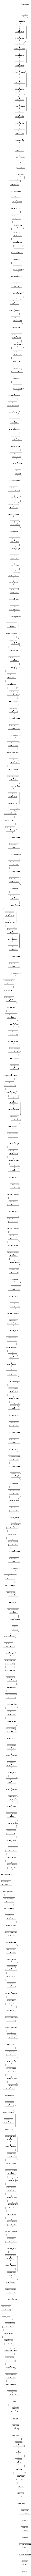

In [0]:
tf.keras.utils.plot_model(model)

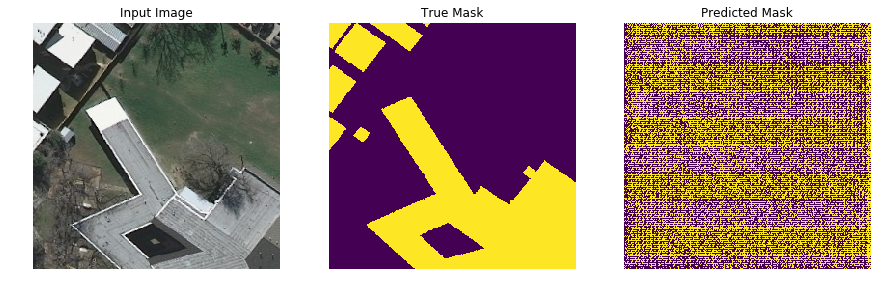

In [0]:
idx = np.random.randint(batch_size)

sample_image = item[0][idx]
sample_mask = item[1][idx]
predicted = model.predict(sample_image[tf.newaxis, ...])[0]
predicted = np.round(predicted)

display([sample_image, sample_mask, predicted])

## Train the model

Finally we add early stopping and a learning rate annealer that reduces the learning rate of a factor $r = 0.75$ when the training reaches a loss plateau. This allows the model to get a little improvement of the IoU score during the last $15$ epochs.

In [0]:
sess = tf.keras.backend.get_session()

In [0]:
%%capture

training_enqueuer = tf.keras.utils.OrderedEnqueuer(train_generator,
                                                   use_multiprocessing=True,
                                                   shuffle=False)

training_enqueuer.start(workers=mp.cpu_count())
next(training_enqueuer.get())

In [0]:
epochs = 35

checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5',
                                                monitor='val_iou',
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min', 
                                              patience=5,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode="min",
                                                 min_lr=1e-6,
                                                 factor=0.75,
                                                 patience=1,
                                                 verbose=1)

callbacks = [reduce_lr, early_stop, checkpoint]

score = model.fit_generator(train_generator,
                            steps_per_epoch=train_generator.n,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=validation_generator.n,
                            verbose=1,
                            callbacks=callbacks,
                            use_multiprocessing=True,
                            max_queue_size=2 * mp.cpu_count(),
                            workers=mp.cpu_count())

Epoch 1/35
1146/1147 [============================>.] - ETA: 0s - loss: 0.3383 - iou: 0.7045 - binary_accuracy: 0.8865
Epoch 00001: val_iou improved from -inf to 0.75598, saving model to weights.h5
1147/1147 [==============================] - 1275s 1s/step - loss: 0.3382 - iou: 0.7046 - binary_accuracy: 0.8865 - val_loss: 0.2748 - val_iou: 0.7560 - val_binary_accuracy: 0.9115
Epoch 2/35
1146/1147 [============================>.] - ETA: 0s - loss: 0.2732 - iou: 0.7542 - binary_accuracy: 0.9131
Epoch 00002: val_iou improved from 0.75598 to 0.76518, saving model to weights.h5
1147/1147 [==============================] - 837s 730ms/step - loss: 0.2732 - iou: 0.7541 - binary_accuracy: 0.9131 - val_loss: 0.2645 - val_iou: 0.7652 - val_binary_accuracy: 0.9155
Epoch 3/35
1146/1147 [============================>.] - ETA: 0s - loss: 0.2515 - iou: 0.7730 - binary_accuracy: 0.9209
Epoch 00003: val_iou improved from 0.76518 to 0.78310, saving model to weights.h5
1147/1147 [=========================

## Results

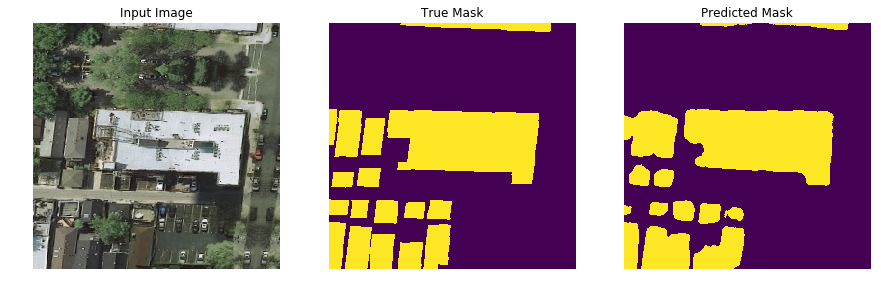

In [0]:
idx = np.random.randint(batch_size)

sample_image = item[0][idx]
sample_mask = item[1][idx]
predicted = model.predict(sample_image[tf.newaxis, ...])[0]
predicted = np.round(predicted)

display([sample_image, sample_mask, predicted])

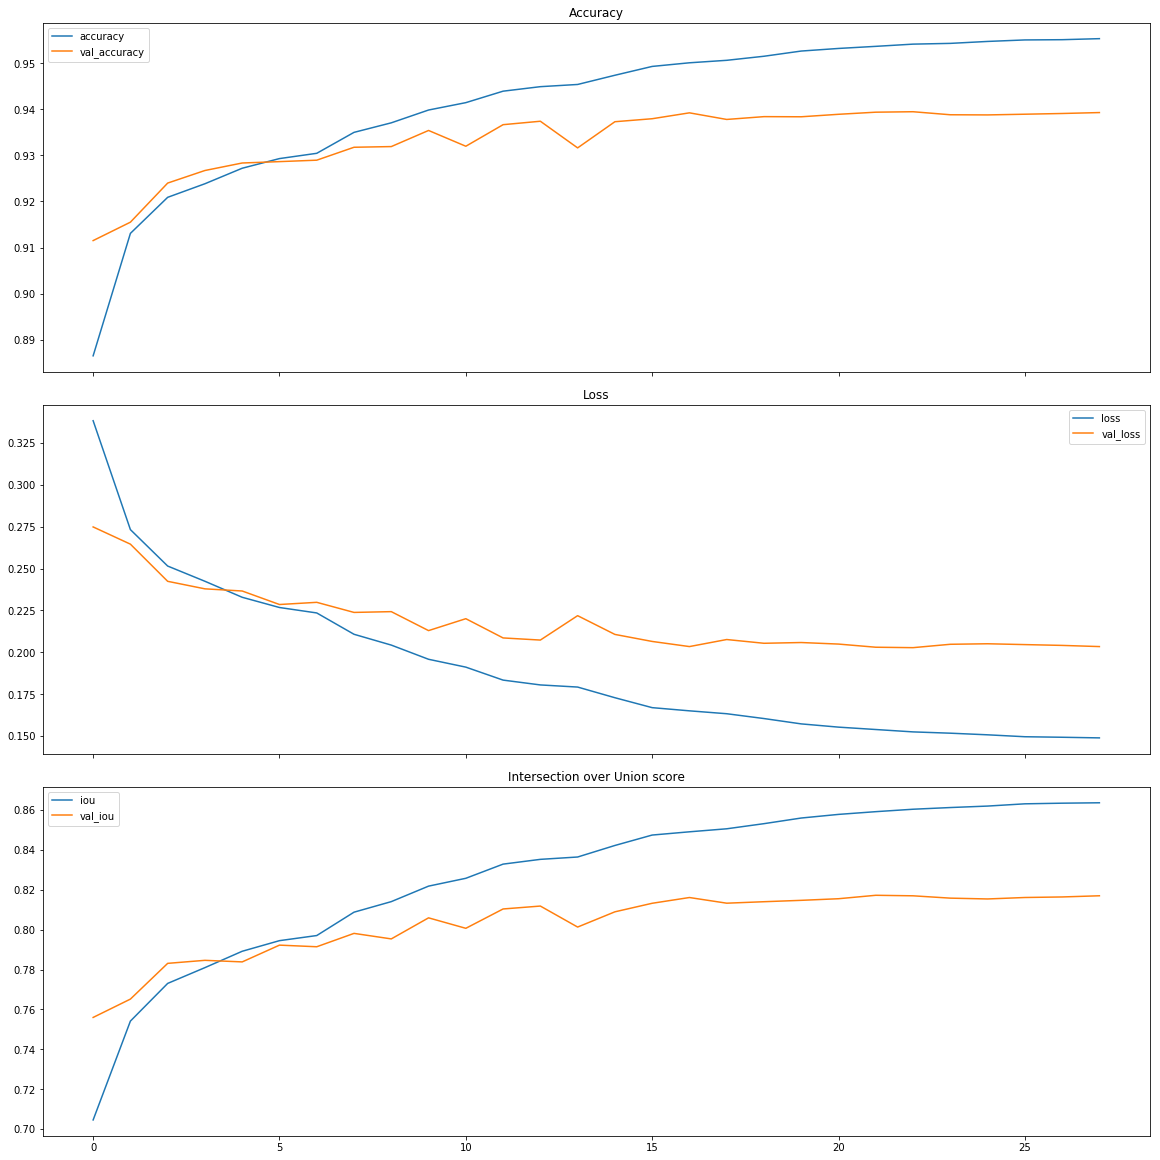

In [0]:
fig, ax = plt.subplots(3, 1, figsize=(16,16), sharex=True, constrained_layout=True)

iou_score = score.history['binary_accuracy']
ax[0].plot(range(len(iou_score)), iou_score, label="accuracy")

iou_score = score.history['val_binary_accuracy']
ax[0].plot(range(len(iou_score)), iou_score, label="val_accuracy")

ax[0].legend()
ax[0].set_title("Accuracy")

loss = score.history['loss']
ax[1].plot(range(len(loss)), loss, label="loss")

loss = score.history['val_loss']
ax[1].plot(range(len(loss)), loss, label="val_loss")

ax[1].legend()
ax[1].set_title("Loss")

iou_score = score.history['iou']
ax[2].plot(range(len(iou_score)), iou_score, label="iou")

iou_score = score.history['val_iou']
ax[2].plot(range(len(iou_score)), iou_score, label="val_iou")

ax[2].legend()
ax[2].set_title("Intersection over Union score")

plt.show()

In [0]:
model.load_weights('weights.h5')

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=[iou])

In [0]:
loss, score = model.evaluate_generator(validation_generator,
                                       use_multiprocessing=True,
                                       workers=mp.cpu_count())

print("Validation Loss: %.4f" % (loss))
print("Validation IoU: %.4f" % (score))

Validation Loss: 0.2332
Validation IoU: 0.8172


In [0]:
def calculate_competition_score(score):
    thresholds = np.arange(0.5, 1.0, 0.05)
    competition_score = 0

    for t in thresholds:
        if score > t:
            competition_score += 1

    competition_score /= len(thresholds)
    
    return competition_score
    
print("Leaderboard Score: %.4f" % (calculate_competition_score(score)))

Leaderboard Score: 0.7000


## Predictions on test data

In [0]:
test_dir = input_dir + "test"

filenames_test = os.listdir(test_dir + "/images/img")

test_images = np.zeros((len(filenames_test), *input_shape))

for idx, fname in enumerate(filenames_test):
    img = cv2.imread(test_dir + "/images/img/" + fname)
    img = preprocess_input([img], input_shape)[0]
    if tf.keras.backend.image_data_format() == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    test_images[idx] = img

In [0]:
def augment_images(images):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10)),
        iaa.Fliplr(.4)
    ], random_order=True)
    
    seq = seq.to_deterministic()
    images = seq.augment_images(images)
    return images

class TestDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 input_shape,
                 batch_size=1):
        
            
        self.images = images

        self.input_shape = input_shape
        
        self.batch_size = batch_size
        
        self.epoch = 0
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.n = self.__len__()
        self.epoch += 1

    def __len__(self):
        return int(np.ceil(self.images.shape[0] / self.batch_size))
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                                     (step + 1) * self.batch_size]

        X = self.__generate_batch(current_images)
        return X
    
    def __generate_batch(self, images):
        X = np.zeros((self.batch_size, *self.input_shape))
        
        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            
        return X

In [0]:
test_generator = TestDataGenerator(test_images,
                                   input_shape=input_shape)

predictions = model.predict_generator(test_generator,
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count())

pred_mask = np.round(predictions)

1234/1234 [==============================] - 97s 78ms/step


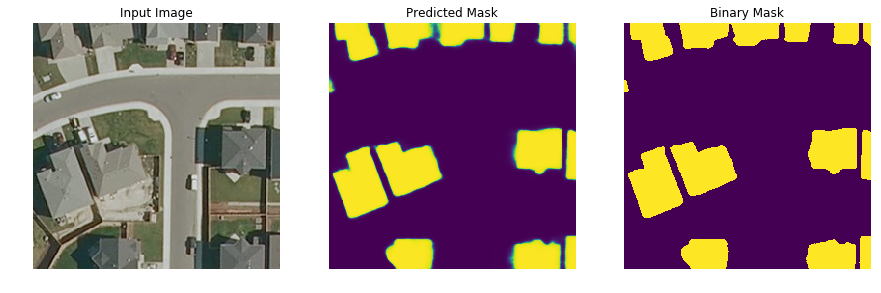

In [0]:
idx = np.random.randint(len(predictions))
display([test_images[idx], predictions[idx], pred_mask[idx]],
        title=['Input Image', 'Predicted Mask', 'Binary Mask'])

In [0]:
def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
encoded_predictions = [rle_encode(img) for img in pred_mask]

In [0]:
import os
from datetime import datetime

def create_csv(results, results_dir='./', csv_fname='submission.csv'):

    with open(csv_fname, 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

In [0]:
results = {}
for idx, image_name in enumerate(filenames_test):
    image_name = image_name.split(".")[0]
    results[image_name] = encoded_predictions[idx]

csv_fname = 'submission.csv'           
create_csv(results, csv_fname=csv_fname)

In [0]:
submission = pd.read_csv(csv_fname)
submission.head()

ImageId                                      EncodedPixels  Width  Height
0     7567  1 87 257 85 513 82 769 77 1025 71 1281 64 1537...    256     256
1     8043  68 26 324 26 586 11 598 2 8112 33 8147 8 8165 ...    256     256
2     4712  17 10 38 26 70 25 103 24 131 21 163 21 194 49 ...    256     256
3     1167  68 70 155 85 253 4 324 70 411 85 509 4 581 69 ...    256     256
4     7331  8589 2 8845 2 8879 1 9101 2 9135 3 9357 3 9391...    256     256

In [0]:
%%capture

!pip uninstall -y kaggle
!pip install kaggle

In [0]:
os.environ["KAGGLE_USERNAME"] = "lazcoder"
os.environ["KAGGLE_KEY"] = "f8513d63f03470f5f848e303e747159c"

In [0]:
!kaggle competitions submit -c ann-and-dl-image-segmentation -f {csv_fname} -m ""